# Modeling 

In [1]:
import pandas as pd
from datetime import datetime
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xgboost as xgb
from sklearn.linear_model import SGDClassifier
from IPython.display import display
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_selection import SelectKBest, f_classif

C:\Users\Papasmurfff\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data

### App Events

In [2]:
app_events=pd.read_csv('app_events.csv', usecols=['event_id', 'app_id', 'is_active'], dtype={'is_active':bool})

In [3]:
display(app_events.head())
print(app_events.shape)

,event_id,app_id,is_active
0,2,5927333115845830913,True
1,2,-5720078949152207372,False
2,2,-1633887856876571208,False
3,2,-653184325010919369,True
4,2,8693964245073640147,True


(32473067, 3)


### App Labels

In [4]:
app_labels= pd.read_csv('app_labels.csv')
display(app_labels.head())
print(app_labels.shape)

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


(459943, 2)


### Events

In [5]:
events= pd.read_csv('events.csv', index_col='event_id', parse_dates=['timestamp'])

C:\Users\Papasmurfff\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
display(events.head())
print(events.shape)

,device_id,timestamp,longitude,latitude
event_id,,,,
1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


(3252950, 4)


### Label Categories

In [7]:
label_categories= pd.read_csv('label_categories.csv')
display(label_categories.head())
print(label_categories.shape)



,label_id,category
0,1,NaN
1,2,game-game type
2,3,game-Game themes
3,4,game-Art Style
4,5,game-Leisure time


(930, 2)


### Phone Brand

In [8]:
phone_brand= pd.read_csv('phone_brand_device_model.csv')
phone_brand = phone_brand.drop_duplicates('device_id').set_index('device_id')
display(phone_brand.head())
print(phone_brand.shape)

,phone_brand,device_model
device_id,,
-8890648629457979026,小米,红米
1277779817574759137,小米,MI 2
5137427614288105724,三星,Galaxy S4
3669464369358936369,SUGAR,时尚手机
-5019277647504317457,三星,Galaxy Note 2


(186716, 2)


### Train Set

In [9]:
gender_age_train= pd.read_csv('gender_age_train.csv', index_col='device_id')
display(gender_age_train.head())
print(gender_age_train.shape)

,gender,age,group
device_id,,,
-8076087639492063270,M,35,M32-38
-2897161552818060146,M,35,M32-38
-8260683887967679142,M,35,M32-38
-4938849341048082022,M,30,M29-31
245133531816851882,M,30,M29-31


(74645, 3)


In [10]:
gender_age_test= pd.read_csv('gender_age_test.csv', index_col='device_id')

# Modeling with Brand/Model as Features Only


In [13]:
app_events_merged = app_events.merge(events[['device_id']], how='left', left_on='event_id', right_index=True)

### Benchmark

In [11]:
#creating columns to show which device_id is in the training

gender_age_train['trainrow'] = np.arange(gender_age_train.shape[0])

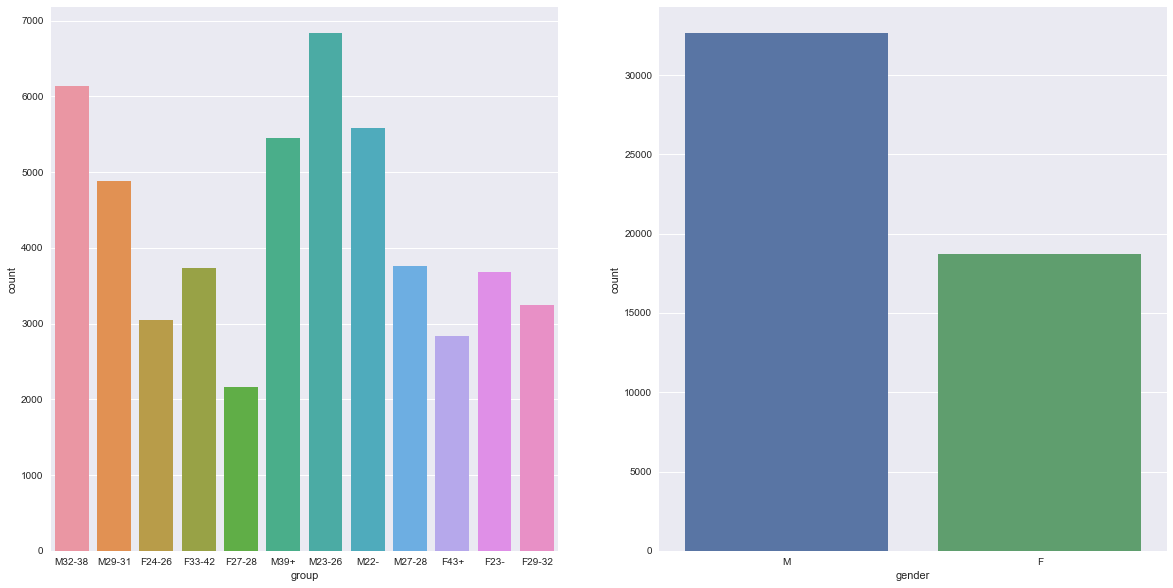

In [245]:
fig = plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.countplot(train_phone['group'])

plt.subplot(1,2,2)
sns.countplot(train_phone['gender'])

In [14]:
train_phone = gender_age_train[~gender_age_train.index.isin(app_events_merged['device_id'])]
train_phone = train_phone.merge(phone_brand, left_index=True, right_index=True, how='left')
train_phone_ = train_phone[['phone_brand', 'device_model']]

train_phone_ = pd.get_dummies(train_phone_)

In [15]:
train_phone_.shape

(51355, 1489)

In [16]:
le= LabelEncoder()
target_group_phone = le.fit_transform(train_phone['group'])
target_gender_phone = le.fit_transform(train_phone['gender'])

In [17]:
agegroup_bench = train_phone['group'].value_counts()[0]/train_phone['group'].value_counts().sum()
gender_bench = train_phone['gender'].value_counts()[0]/train_phone['gender'].value_counts().sum()


print('Gender and Age Group Benchmark: {} \nGender Benchmark: {}'.format(agegroup_bench, gender_bench))

Gender and Age Group Benchmark: 0.13309317495862136 
Gender Benchmark: 0.6358290332002726


### Logistic Regression

In [225]:
for targets, i in [(target_group_phone,'Age Group'), (target_gender_phone, 'Gender')]:
        
    print('{} Best Score:'.format(i))    
    lr = GridSearchCV(LogisticRegression(), {'C':np.logspace(-3,-1, 5)}, n_jobs=-1, cv= sss)
    lr.fit(train_phone_, targets)
    
    print(pd.DataFrame(lr.cv_results_)['mean_test_score'][pd.DataFrame(lr.cv_results_)['rank_test_score']==1])


Age Group Best Score:
4    0.15387
Name: mean_test_score, dtype: float64
Gender Best Score:
4    0.64023
Name: mean_test_score, dtype: float64


# Modeling with Apps  as Features Only

In [18]:
train_apps = gender_age_train[gender_age_train.index.isin(app_events_merged['device_id'])]

In [19]:
train_apps['trainrow'] = np.arange(train_apps.shape[0])

C:\Users\Papasmurfff\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
train_apps.shape

(23290, 4)

In [21]:
appencoder = LabelEncoder().fit(app_events['app_id'])
apps = appencoder.transform(app_events['app_id'])

app_events_merged['apps'] = apps


In [27]:
#creating Sparse Matrix

d = (app_events_merged.groupby(['device_id', 'apps'])['apps'].agg(['size'])
     .merge(train_apps[['trainrow']],how='right', left_index=True, right_index=True)
     .reset_index() 
    )

sparse_app_train = csr_matrix(
        (np.ones(d.shape[0]), (d['trainrow'], d['apps'])), shape = (train_apps.shape[0],app_events['apps'].nunique())
                                )

In [28]:
sparse_app_train.shape

(23290, 19237)

In [29]:
le= LabelEncoder()
target_group_apps = le.fit_transform(train_apps['group'])
target_gender=le.fit_transform(train_apps['gender'])

## BenchMark

In [232]:
agegroup_bench = train_apps['group'].value_counts()[0]/train_apps['group'].value_counts().sum()
gender_bench = train_apps['gender'].value_counts()[0]/train_apps['gender'].value_counts().sum()


print('Gender and Age Group Benchmark: {} \nGender Benchmark: {}'.format(agegroup_bench, gender_bench))

Gender and Age Group Benchmark: 0.1433233147273508 
Gender Benchmark: 0.6548303993130099


## Logistic Regression Prediction for Age Group and Gender with Apps only

In [233]:
sss = StratifiedShuffleSplit(train_size=.8, test_size=.2, n_splits=5, random_state=18)

for targets, i in [(target_group_apps,'Gender and Age Group'), (target_gender, 'Gender')]:
        
    print('{} Best Score:'.format(i))    
    lr = GridSearchCV(LogisticRegression(), {'C':np.logspace(-3,-1, 5)}, n_jobs=-1, cv= sss)
    lr.fit(sparse_app_train, targets)
    
    print(pd.DataFrame(lr.cv_results_)['mean_test_score'][pd.DataFrame(lr.cv_results_)['rank_test_score']==1])



Gender and Age Group Best Score:
3    0.292486
Name: mean_test_score, dtype: float64
Gender Best Score:
3    0.771318
Name: mean_test_score, dtype: float64


### SGD 

In [238]:

for targets, i in [(target_group_apps,'Gender and Age Group'), (target_gender, 'Gender')]:
    print('{} Best Score:'.format(i))
    sgd = GridSearchCV(SGDClassifier(), {'alpha': np.logspace(-4,4,20), 'n_iter':[5,10]}, cv=sss, n_jobs=-1)
    sgd.fit(sparse_app_train, targets)
    print(pd.DataFrame(sgd.cv_results_)['mean_test_score'][pd.DataFrame(sgd.cv_results_)['rank_test_score']==1])

Gender and Age Group Best Score:
12    0.276385
Name: mean_test_score, dtype: float64
Gender Best Score:
7    0.769515
Name: mean_test_score, dtype: float64
